In [1]:
# import packages
import pandas as pd
import sklearn.metrics

pd.options.mode.chained_assignment = None
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import (
    LogisticRegression
)

from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
    GradientBoostingClassifier
)
from imblearn.ensemble import BalancedBaggingClassifier
import xgboost as xgb

import optuna
from optuna.samplers import RandomSampler, TPESampler
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb

import scipy.stats as st
import os

from training import (
    plot_auc_roc, plot_recision_recall_f1, 
    plot_countbar, plot_line,
    plot_diff_in_means, plot_cross_tab_heatmap, 
    plot_predictions_by_scores,
    model_training
)

from datetime import datetime
import logging
NOW = datetime.today().isoformat()[:19]
logging.basicConfig(
    filemode='a',
    filename=f'./logs/{NOW}_outputlog.log',
    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
    datefmt='%H:%M:%S',
    level=logging.INFO
)

logger = logging.getLogger(__name__)
optuna.logging.enable_propagation()  # Send optuna logs to the root logger.
logger.info("++++++++++++++++++++++++++++++++++++++++++++++++++++")

In [2]:
list_of_file_names = []
for file in os.listdir('data_full_review_cleaned/'):
   if file.endswith(".json"):
      list_of_file_names.append(os.path.join(file))

In [3]:
list_of_foundations = pd.read_csv('foundation_from_sephora_with_url.csv')
list_of_foundations.head()

,Unnamed: 0,brand_product,url,url_valid
0,0,AMOREPACIFIC_Color_Control_Cushion_Compact_Bro...,https://www.sephora.com/product/color-control-...,1
1,1,Anastasia_Beverly_Hills_Luminous_Foundation,https://www.sephora.com/product/luminous-found...,1
2,2,Anastasia_Beverly_Hills_Stick_Foundation,https://www.sephora.com/product/stick-foundati...,1
3,3,Antonym_Certified_Organic_Baked_Foundation,https://www.sephora.com/product/certified-orga...,1
4,4,Antonym_Skin_Esteem_Organic_Liquid_Foundation,https://www.sephora.com/product/skin-esteem-or...,1


In [4]:
list_of_foundations['model'] = None
list_of_foundations['threshold'] = float()

  0%|          | 0/2 [00:00<?, ?it/s][I 2022-02-11 16:04:28,915] A new study created in memory with name: Dr._Jart+_Premium_Beauty_Balm_SPF_40
[I 2022-02-11 16:04:28,974] Trial 0 finished with value: 0.8218487394957984 and parameters: {'booster': 'gblinear', 'lambda': 0.002850593747819336, 'alpha': 0.28511873529098775}. Best is trial 0 with value: 0.8218487394957984.
[I 2022-02-11 16:04:29,022] Trial 1 finished with value: 0.6773109243697478 and parameters: {'booster': 'gblinear', 'lambda': 0.046368161895394125, 'alpha': 8.925847409246967e-05}. Best is trial 1 with value: 0.6773109243697478.
[I 2022-02-11 16:04:29,078] Trial 2 finished with value: 0.6285714285714284 and parameters: {'booster': 'gblinear', 'lambda': 2.479171351016658e-06, 'alpha': 6.616017652136631e-06}. Best is trial 2 with value: 0.6285714285714284.
[I 2022-02-11 16:04:29,137] Trial 3 finished with value: 0.6436974789915966 and parameters: {'booster': 'gblinear', 'lambda': 1.465045661096827e-05, 'alpha': 1.08890673166

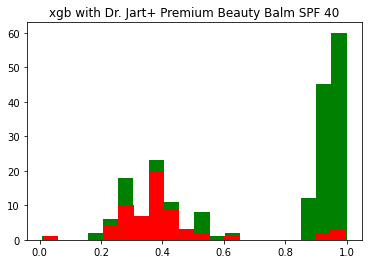

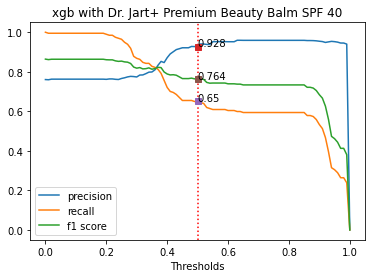

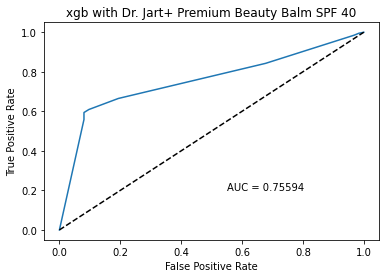

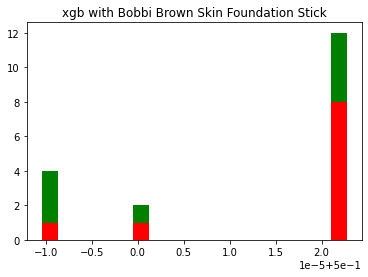

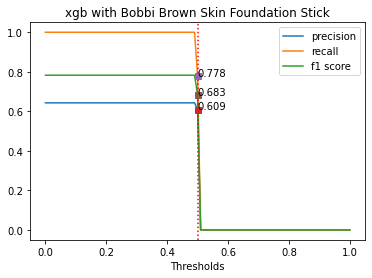

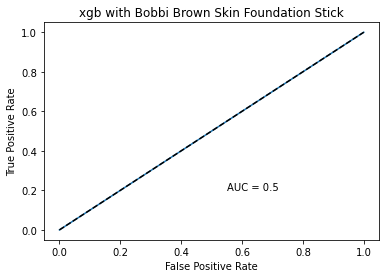

In [5]:
for i in tqdm(range(0, 2)):
    model = model_training(file_name = list_of_file_names[i], random_seeds = 2, logger = logger)
    model.feature_engineering()

    model.training_xgb_model()
    best_f1_threshold = model.thresholding()

    index = list_of_foundations.index[list_of_foundations['brand_product'] == model.product_name].tolist()[0]
    list_of_foundations.loc[index, 'model'] = f'{model.product_name}_xgb.model'
    list_of_foundations.loc[index, 'threshold'] = best_f1_threshold

    model.plot_predictions_by_scores(val_y = model.val_y, product=model.product_name, model = 'xgb')
    model.plot_precision_recall_f1(val_y=model.val_y, product=model.product_name, model='xgb')
    model.plot_auc_roc(val_y=model.val_y, product=model.product_name, model = 'xgb')


In [10]:
model.skin_tone_one_hot_train.columns.to_list()

['Dark', 'Deep', 'Ebony', 'Fair', 'Light']

In [8]:
model.train_X.groupby(['skin_tone'], as_index=False).count()['skin_tone']

0     Ebony
1     Light
2    Medium
3     Olive
4       Tan
Name: skin_tone, dtype: object

In [15]:
test = model_training(file_name=list_of_file_names[0],logger = logger, random_seeds=0)

In [26]:
test_train_X, test_val_X, test_train_y, test_val_y = train_test_split(test.X, test.y, test_size=0.3)

In [27]:
test_train_X.index

Int64Index([844, 182,  74, 576, 103, 717, 217, 836, 334, 170,
            ...
            792, 270, 645, 352, 841, 569, 829, 658, 373, 657],
           dtype='int64', length=621)

In [28]:
test_train_y.index

Int64Index([844, 182,  74, 576, 103, 717, 217, 836, 334, 170,
            ...
            792, 270, 645, 352, 841, 569, 829, 658, 373, 657],
           dtype='int64', length=621)

In [30]:
test_train_y = test_train_y.drop(index=test_train_X[test_train_X['hair_color'] == 'Gray'].index)

In [31]:
test_train_X = test_train_X.drop(index=test_train_X[test_train_X['hair_color'] == 'Gray'].index)

In [32]:
len(test_train_X)

614

In [33]:
len(test_train_y)

614

In [35]:
idx[0]

'Auburn'

In [19]:
len(test.data)

888

In [20]:
test.data = test.data.drop(index = test.data[test.data['hair_color'] == idx[0]].index)

In [21]:
len(test.data)

833

In [19]:
eye_p = test.data.groupby(['eye_color']).count()['reviewer_id']/len(test.data)

In [20]:
eye_p.index

Index(['Blue', 'Brown', 'Green', 'Hazel'], dtype='object', name='eye_color')

In [22]:
eye_count = test.data.groupby(['eye_color']).count()['reviewer_id']#/len(preparing_the_data.data)

In [23]:
eye_count.index

Index(['Blue', 'Brown', 'Green', 'Hazel'], dtype='object', name='eye_color')

In [24]:
idx = eye_count[eye_count<5].index

In [25]:
idx

Index([], dtype='object', name='eye_color')

In [26]:
p_idx = eye_p[eye_p<=0.1].index

In [27]:
p_idx

Index([], dtype='object', name='eye_color')

In [51]:
from sklearn.preprocessing import OneHotEncoder
enc_rest = OneHotEncoder(sparse=False)

train_X_transform = enc_rest.fit_transform(preparing_the_data.train_X[['hair_color']])

In [52]:
train_X_transform = pd.DataFrame(train_X_transform)

In [53]:
col_names_dict = dict()
col = 'hair_color'
import re

cols_cat = preparing_the_data.data.groupby([col], as_index=False).count()[col]
if re.match('^.*_color$', col):
    color = re.split('_color', col)[0]
    cols_cat = cols_cat.str.cat(pd.Series([color] * len(preparing_the_data.data)), sep='_')
    # print(cols_cat)

for col_idx in train_X_transform.columns:
    col_names_dict[col_idx] = cols_cat[col_idx]
    train_X_transform.rename(columns=col_names_dict, inplace=True)

In [55]:
dropped_columns = []
for c in train_X_transform.columns:
    if sum(train_X_transform[c]) < 20:
        dropped_columns.append(c)
        train_X_transform = train_X_transform.drop(columns=c)

In [56]:
train_X_transform

,Black_hair,Blonde_hair,Brunette_hair
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
122,1.0,0.0,0.0
123,0.0,1.0,0.0
124,1.0,0.0,0.0
125,1.0,0.0,0.0


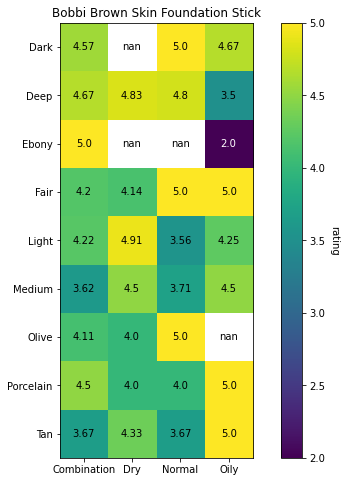

In [17]:
plot_cross_tab_heatmap(data = test.data, col1 = 'skin_tone', col2 = 'skin_type', product=test.product_name, col3 = 'rating')

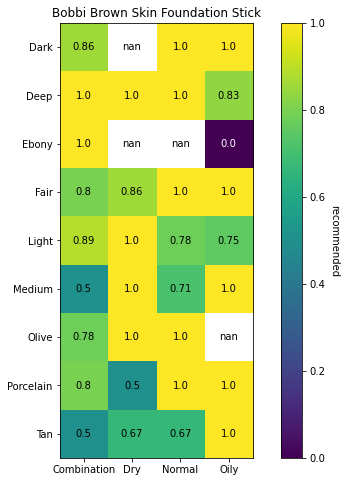

In [19]:
plot_cross_tab_heatmap(data = test.data, col1 = 'skin_tone', col2 = 'skin_type', product=test.product_name, col3 = 'recommended')

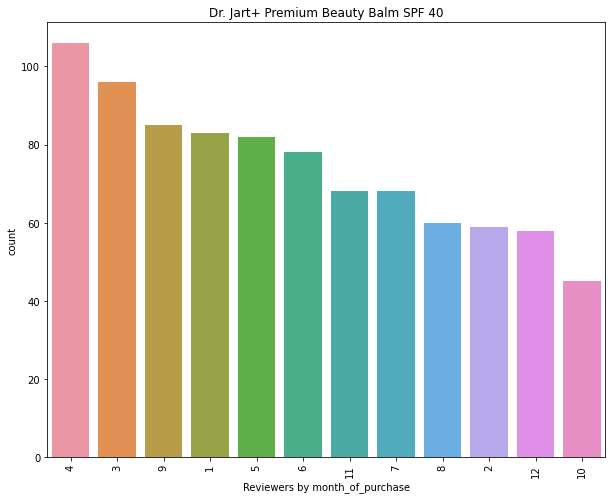

In [6]:
plot_countbar(data = test.data, product = test.product_name, col1 = 'month_of_purchase')

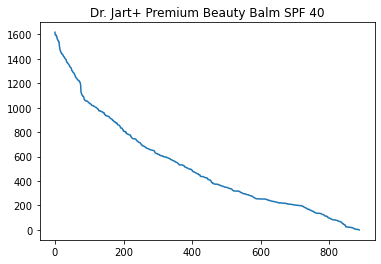

In [7]:
plot_line(data = test.data, product = test.product_name, col1 = 'days_since_launch')

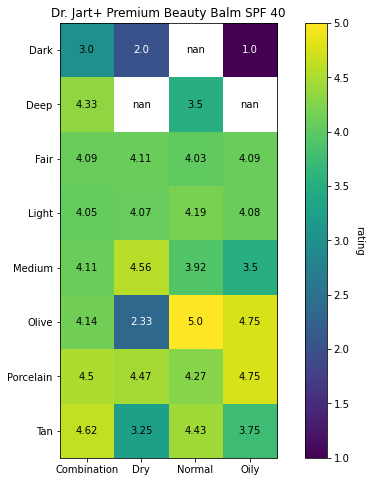

In [8]:
plot_cross_tab_heatmap(data = test.data, product= test.product_name, col1 = 'skin_tone', col2 = 'skin_type', col3 = 'rating')

In [9]:
sum(test.y) / len(test.data)

0.8040540540540541

In [10]:
len(test_train_X[test_train_X.notna()])

621

In [11]:
logit = LogisticRegression(penalty='none',random_state=0, max_iter=1000, class_weight='balanced').fit(test_train_X, test.train_y)

In [12]:
predict_y = logit.predict_proba(test_val_X)[:, 1]

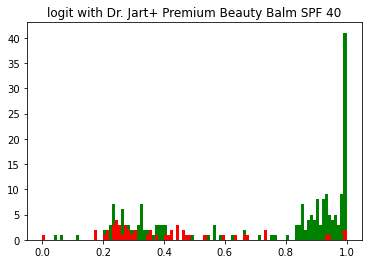

<Figure size 432x288 with 0 Axes>

In [13]:
plot_predictions_by_scores(predict_y, test.val_y, bins = 100, model = 'logit', product= test.product_name)

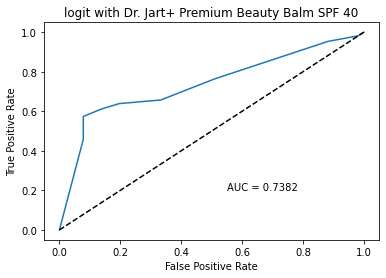

In [14]:
plot_auc_roc(predict_y, test.val_y, product = test.product_name, model = 'logit')

In [15]:
bbc = BalancedBaggingClassifier(random_state=0).fit(test_train_X, test.train_y)
predict_y = bbc.predict_proba(test_val_X)[:, 1]

In [16]:
# Bag = BaggingClassifier(n_estimators=1000, random_state=0).fit(test_train_X, test.train_y)
# predict_y = Bag.predict_proba(test_val_X)[:, 1]

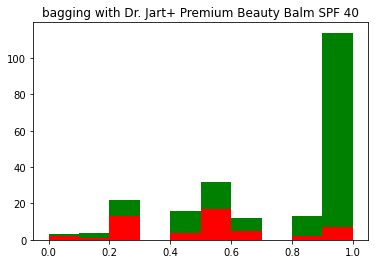

<Figure size 432x288 with 0 Axes>

In [16]:
plot_predictions_by_scores(predict_y, test.val_y, bins = 10, model = 'bagging', product= test.product_name)

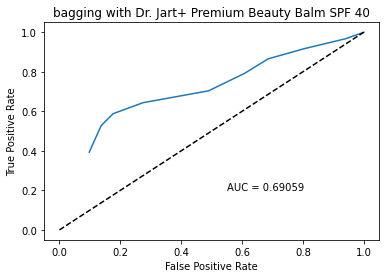

In [17]:
plot_auc_roc(predict_y, test.val_y, product = test.product_name, model = 'bagging')

### Trying out XGBoost

In [7]:
test.data.head()

,reviewer_id,rating,recommended,review_subject,review_content,reviewer_feature,purchased_shade,date_of_review,eye_color,hair_color,...,skin_type,skin_tone_bin,skin_tone_cat,days_since_launch,days_since_launch_scaled,month_of_purchase,finish,coverage,shade_match,gifted
0,LTTop,5,1,Best BB Cream,Over the years I have tried many brands of mak...,", Combination skin",Light - Medium,1643673600000,Hazel,Brunette,...,Combination,0,1,1618,1.000000,2,0,0,0,0
1,tmgre,4,1,Great product/terrible container,Product is very nice and goes on smoothly. I l...,", Normal skin",Light - Medium,1641859200000,Blue,Blonde,...,Normal,0,1,1597,0.987021,1,0,0,0,0
2,sarahkate27,4,1,"Smooth, Natural-Looking, Buildable Coverage",I have been using this product for about 3 yea...,", Oily skin",Light - Medium,1641772800000,Blue,Blonde,...,Oily,0,1,1596,0.986403,1,0,1,1,0
3,emmykay97,4,1,None,I have been using this product for about 3 yea...,", Combination skin",Light - Medium,1641686400000,Green,Auburn,...,Combination,0,1,1595,0.985785,1,0,1,1,0
4,scc37,4,1,Nice lightweight dewy product - hard to get out,Taking a star off because the last tube I got ...,", Dry skin",Light - Medium,1641686400000,Blue,Blonde,...,Dry,0,1,1595,0.985785,1,0,1,1,0


In [10]:
new = training_models(file_name=list_of_file_names[0])

TypeError: __init__() takes 2 positional arguments but 3 were given

In [23]:
test.train_y

AttributeError: 'training_models' object has no attribute 'train_y'

In [18]:
train_p_1 = len(test.train_y) / (len(test.train_y[test.train_y == 1]) * 2)
train_p_0 = len(test.train_y) / (len(test.train_y[test.train_y == 0]) * 2)

val_p_1 = len(test.val_y) / (len(test.val_y[test.val_y == 1]) * 2) 
val_p_0 = len(test.val_y) / (len(test.val_y[test.val_y == 0]) * 2) 
# val_p = len(test.val_y) / (len(test.val_y) * 2) 
# wj= n_samples / (n_classes * n_samplesj)
w_train = np.where(test.train_y == 0, train_p_0, train_p_1)
w_val = np.where(test.val_y == 0, val_p_0, val_p_1)

dtrain = xgb.DMatrix(test_train_X, label = test.train_y, weight=w_train)
dval = xgb.DMatrix(test_val_X, label = test.val_y, weight=w_val)

In [19]:
param = {'max_depth': 7, 'objective': 'binary:logistic', 'eta': 0.1, 'lambda': 1, 'alpha': 0, 'gamma': 5}
param['nthread'] = 4
param['eval_metric'] = 'auc'
evallist = [(dval, 'eval'), (dtrain, 'train')]

In [20]:
num_round = 15
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-auc:0.75617	train-auc:0.77471
[1]	eval-auc:0.75617	train-auc:0.77471
[2]	eval-auc:0.76888	train-auc:0.81297
[3]	eval-auc:0.76888	train-auc:0.81297
[4]	eval-auc:0.74973	train-auc:0.84432
[5]	eval-auc:0.74986	train-auc:0.84433
[6]	eval-auc:0.74292	train-auc:0.84869
[7]	eval-auc:0.74292	train-auc:0.84869
[8]	eval-auc:0.74292	train-auc:0.84869
[9]	eval-auc:0.74292	train-auc:0.84869
[10]	eval-auc:0.74292	train-auc:0.84869
[11]	eval-auc:0.74292	train-auc:0.84873
[12]	eval-auc:0.74519	train-auc:0.84847
[13]	eval-auc:0.72812	train-auc:0.88357
[14]	eval-auc:0.73693	train-auc:0.88811


In [155]:
# os.makedirs(f'models/{test.product_name}')
bst.save_model(f'models/{test.product_name}/{test.product_name}_xgboost.model')

In [56]:
params = hyperparameter_tune(X_train = test_train_X,
        y_train = test.train_y,
        X_valid = test_val_X,
        y_valid = test.val_y,
        n_trials = 10)

[I 2022-02-08 16:56:42,397] A new study created in memory with name: no-name-206de28f-59e5-429b-bbfb-7b767f8a080e


[0]	validation-auc:0.50000	train-auc:0.50000
[1]	validation-auc:0.50000	train-auc:0.50000
[2]	validation-auc:0.50000	train-auc:0.50000
[3]	validation-auc:0.72767	train-auc:0.77510
[4]	validation-auc:0.72767	train-auc:0.77510
[5]	validation-auc:0.72767	train-auc:0.77510
[6]	validation-auc:0.72767	train-auc:0.77510
[7]	validation-auc:0.72767	train-auc:0.77811
[8]	validation-auc:0.72168	train-auc:0.81755
[9]	validation-auc:0.72168	train-auc:0.81977


[I 2022-02-08 16:56:42,472] Trial 0 finished with value: 0.6441947565543071 and parameters: {'booster': 'gbtree', 'lambda': 4.5680396563785255e-06, 'alpha': 8.824276748141828e-08, 'max_depth': 8, 'eta': 1.3614190482264298e-08, 'gamma': 0.014386011042876035, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6441947565543071.


[0]	validation-auc:0.75004	train-auc:0.80796
[1]	validation-auc:0.74678	train-auc:0.81423
[2]	validation-auc:0.74823	train-auc:0.81705
[3]	validation-auc:0.74569	train-auc:0.81776
[4]	validation-auc:0.74360	train-auc:0.81704
[5]	validation-auc:0.74088	train-auc:0.81640
[6]	validation-auc:0.73988	train-auc:0.81575
[7]	validation-auc:0.73870	train-auc:0.81531
[8]	validation-auc:0.73779	train-auc:0.81495
[9]	validation-auc:0.73743	train-auc:0.81469


[I 2022-02-08 16:56:42,495] Trial 1 finished with value: 0.6666666666666666 and parameters: {'booster': 'gblinear', 'lambda': 2.0675355708856458e-05, 'alpha': 0.000348340436641141}. Best is trial 0 with value: 0.6441947565543071.


[0]	validation-auc:0.72921	train-auc:0.91743
[1]	validation-auc:0.74247	train-auc:0.93156
[2]	validation-auc:0.74274	train-auc:0.93383
[3]	validation-auc:0.74378	train-auc:0.93413
[4]	validation-auc:0.74256	train-auc:0.94267
[5]	validation-auc:0.74287	train-auc:0.94216
[6]	validation-auc:0.74233	train-auc:0.94289
[7]	validation-auc:0.74387	train-auc:0.94307
[8]	validation-auc:0.74128	train-auc:0.94255
[9]	validation-auc:0.74029	train-auc:0.94207


[I 2022-02-08 16:56:42,577] Trial 2 finished with value: 0.7116104868913857 and parameters: {'booster': 'dart', 'lambda': 0.00012584749896558955, 'alpha': 2.9713805539748287e-05, 'max_depth': 14, 'eta': 1.578620898719132e-07, 'gamma': 1.4514237120453738e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.4816474917262365, 'skip_drop': 0.0034314995956672605}. Best is trial 0 with value: 0.6441947565543071.


[0]	validation-auc:0.74124	train-auc:0.88632
[1]	validation-auc:0.72917	train-auc:0.89015
[2]	validation-auc:0.72871	train-auc:0.88976
[3]	validation-auc:0.72917	train-auc:0.89015
[4]	validation-auc:0.72898	train-auc:0.89001
[5]	validation-auc:0.72917	train-auc:0.89015
[6]	validation-auc:0.72962	train-auc:0.89001
[7]	validation-auc:0.73103	train-auc:0.89690
[8]	validation-auc:0.73085	train-auc:0.89695
[9]	validation-auc:0.73103	train-auc:0.89685


[I 2022-02-08 16:56:42,624] Trial 3 finished with value: 0.6704119850187266 and parameters: {'booster': 'gbtree', 'lambda': 7.643363924215666e-07, 'alpha': 0.00016547478805294894, 'max_depth': 10, 'eta': 0.005007109939657118, 'gamma': 0.9178716269988172, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6441947565543071.


[0]	validation-auc:0.75123	train-auc:0.81131
[1]	validation-auc:0.74687	train-auc:0.81519
[2]	validation-auc:0.74487	train-auc:0.81768
[3]	validation-auc:0.74378	train-auc:0.81821
[4]	validation-auc:0.74169	train-auc:0.81737
[5]	validation-auc:0.74060	train-auc:0.81627
[6]	validation-auc:0.74060	train-auc:0.81622
[7]	validation-auc:0.74033	train-auc:0.81572
[8]	validation-auc:0.73961	train-auc:0.81542
[9]	validation-auc:0.73942	train-auc:0.81526


[I 2022-02-08 16:56:42,643] Trial 4 finished with value: 0.6741573033707865 and parameters: {'booster': 'gblinear', 'lambda': 6.967419247582416e-05, 'alpha': 6.7936075951674815e-06}. Best is trial 0 with value: 0.6441947565543071.


[0]	validation-auc:0.73243	train-auc:0.72624
[1]	validation-auc:0.73243	train-auc:0.72624
[2]	validation-auc:0.73243	train-auc:0.72624
[3]	validation-auc:0.72953	train-auc:0.72732
[4]	validation-auc:0.72953	train-auc:0.72732
[5]	validation-auc:0.72953	train-auc:0.72754
[6]	validation-auc:0.72953	train-auc:0.72754
[7]	validation-auc:0.72953	train-auc:0.72754
[8]	validation-auc:0.72953	train-auc:0.72754
[9]	validation-auc:0.72953	train-auc:0.72754


[I 2022-02-08 16:56:42,671] Trial 5 finished with value: 0.6217228464419475 and parameters: {'booster': 'gbtree', 'lambda': 8.124350910750961e-06, 'alpha': 0.0004795606180796081, 'max_depth': 2, 'eta': 0.03195260470143564, 'gamma': 4.279441893328834e-05, 'grow_policy': 'depthwise'}. Best is trial 5 with value: 0.6217228464419475.


[0]	validation-auc:0.75722	train-auc:0.80768


[I 2022-02-08 16:56:42,679] Trial 6 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.72200	train-auc:0.94572
[1]	validation-auc:0.71791	train-auc:0.95008
[2]	validation-auc:0.71764	train-auc:0.95053
[3]	validation-auc:0.71705	train-auc:0.95051
[4]	validation-auc:0.71836	train-auc:0.95038
[5]	validation-auc:0.71845	train-auc:0.95095
[6]	validation-auc:0.71746	train-auc:0.95072
[7]	validation-auc:0.71696	train-auc:0.95096
[8]	validation-auc:0.71768	train-auc:0.95086
[9]	validation-auc:0.71809	train-auc:0.95079


[I 2022-02-08 16:56:42,750] Trial 7 finished with value: 0.7191011235955056 and parameters: {'booster': 'gbtree', 'lambda': 1.8361953762708797e-05, 'alpha': 1.3104909215619443e-06, 'max_depth': 15, 'eta': 2.098535065260438e-05, 'gamma': 1.2306289378095787e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6217228464419475.
[I 2022-02-08 16:56:42,758] Trial 8 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.74650	train-auc:0.80848


[I 2022-02-08 16:56:42,765] Trial 9 pruned. Trial was pruned at iteration 0.


In [57]:
params

{'verbosity': 0,
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'booster': 'gbtree',
 'lambda': 8.124350910750961e-06,
 'alpha': 0.0004795606180796081,
 'max_depth': 2,
 'eta': 0.03195260470143564,
 'gamma': 4.279441893328834e-05,
 'grow_policy': 'depthwise'}

In [58]:
best_model = train_single_run(
    X_train=test_train_X,
    X_valid=test_val_X,
    y_train=test.train_y,
    y_valid=test.val_y,
    parameters=params,
    num_round=10
)

[0]	eval-auc:0.73243	train-auc:0.72624
[1]	eval-auc:0.73243	train-auc:0.72624
[2]	eval-auc:0.73243	train-auc:0.72624
[3]	eval-auc:0.72953	train-auc:0.72732
[4]	eval-auc:0.72953	train-auc:0.72732
[5]	eval-auc:0.72953	train-auc:0.72754
[6]	eval-auc:0.72953	train-auc:0.72754
[7]	eval-auc:0.72953	train-auc:0.72754
[8]	eval-auc:0.72953	train-auc:0.72754
[9]	eval-auc:0.72953	train-auc:0.72754


In [61]:
os.mkdir(f'models/{test.product_name}')
best_model.save_model(f'models/{test.product_name}/{test.product_name}_xgboost.model')

In [52]:
def hyperparameter_tune(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_valid: pd.DataFrame,
    y_valid: pd.Series,
    n_trials: int
) -> dict:
    """
    This function performs the hyperparameter tuning given a training dataset and
    a test dataset.
    Returns the best hyperparameter set
    """
    initial_hyperparams = {
        'verbosity': 0,
        # 'booster': trial.suggest_categorical("booster", ['gbtree', 'gblinear', 'dart']),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        # 'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        # 'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
    }

    # initial_hyperparams = {
    #     'boosting_type': 'gbdt',
    #     'objective': 'binary',
    #     'metric': 'auc',
    #     'num_threads': NUM_CPUS,
    #     'verbose': -1,
    #     'num_boost_round': 7500,
    #     'lambda_l2': 0,
    #     'feature_fraction': 1,
    #     'bagging_fraction': 1,
    #     'bagging_freq': 0,
    #     # 'scale_pos_weight': SCALE_POS_WEIGHT,
    # }

    study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler()
        # sampler=RandomSampler()
    )

    study.optimize(
        lambda trial: objective(
            trial,
            X_train,
            y_train,
            X_valid,
            y_valid
        ),
        # timeout=HYPERPARAM_TIMEOUT,
        n_trials=n_trials,
        n_jobs=1
    )
    tuned_params = study.best_trial.params

    # Replace guessed parameter with concrete best values
    for key, value in tuned_params.items():
        initial_hyperparams[key] = value

    return initial_hyperparams

In [ ]:
def objective(
    trial: optuna.Trial,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_valid: pd.DataFrame,
    y_valid: pd.Series
) -> float:
    """
    The objective function calculated while tuning hyperparameters.
    The suggestions for the next set of hyperparameters on the next round is
    performed using Tree Structured Parzen Estimation. The value being optimized
    for is mse.
    Returns the mse value for the trial calculated on the test set
    """
    train_p_1 = len(y_train) / (len(y_train[y_train == 1]) * 2)
    train_p_0 = len(y_train) / (len(y_train[y_train == 0]) * 2)

    val_p_1 = len(y_valid) / (len(y_valid[y_valid == 1]) * 2)
    val_p_0 = len(y_valid) / (len(y_valid[y_valid == 0]) * 2)

    w_train = np.where(y_train == 0, train_p_0, train_p_1)
    w_val = np.where(y_valid == 0, val_p_0, val_p_1)

    dtrain = xgb.DMatrix(X_train, label = y_train, weight=w_train)
    dval = xgb.DMatrix(X_valid, label = y_valid, weight=w_val)

    hyperparams = {
        'verbosity': 0,
        'booster': trial.suggest_categorical("booster", ['gbtree', 'gblinear', 'dart']),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
    }

    if hyperparams["booster"] == "gbtree" or hyperparams["booster"] == "dart":
        hyperparams["max_depth"] = trial.suggest_int("max_depth", 1, 15)
        hyperparams["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        hyperparams["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        hyperparams["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if hyperparams["booster"] == "dart":
        hyperparams["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        hyperparams["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        hyperparams["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        hyperparams["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(hyperparams, dtrain, evals=[(dval, "validation"), (dtrain, 'train')], callbacks=[pruning_callback])
    predicts = bst.predict(dval)
    predict_y = np.rint(predicts)
    accuracy = sklearn.metrics.accuracy_score(y_valid, predict_y)

    return accuracy


In [33]:
study = optuna.create_study(
        direction='minimize',
        # sampler=TPESampler()
        sampler=RandomSampler()

    )
study.optimize(
    lambda trial: objective(
        trial,
        X_train = test_train_X,
        y_train = test.train_y,
        X_valid = test_val_X,
        y_valid = test.val_y
    ),
    # timeout=HYPERPARAM_TIMEOUT,
    n_trials=10,
    n_jobs=1
)
logger.info(f"##########################")
logger.info(f"Best trial from optuna is {study.best_trial}")
logger.info(f"Best hyperparameters from optuna is {study.best_params}")
logger.info(f"##########################")

[I 2022-02-08 16:21:17,904] A new study created in memory with name: no-name-da68af7f-d920-4ed3-aac9-1209282f3ed1


[0]	validation-auc:0.74365	train-auc:0.78517
[1]	validation-auc:0.74333	train-auc:0.78531
[2]	validation-auc:0.74333	train-auc:0.78526
[3]	validation-auc:0.74333	train-auc:0.78531
[4]	validation-auc:0.74333	train-auc:0.78531
[5]	validation-auc:0.74333	train-auc:0.78531
[6]	validation-auc:0.74333	train-auc:0.78531
[7]	validation-auc:0.74333	train-auc:0.78531
[8]	validation-auc:0.74333	train-auc:0.78531
[9]	validation-auc:0.74333	train-auc:0.78531


[I 2022-02-08 16:21:17,959] Trial 0 finished with value: 0.6554307116104869 and parameters: {'booster': 'gbtree', 'lambda': 1.2932438004915203e-08, 'alpha': 1.793870717538089e-08, 'max_depth': 6, 'eta': 4.702875370844045e-06, 'gamma': 1.2110748804078487e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.6554307116104869.


[0]	validation-auc:0.75313	train-auc:0.89445
[1]	validation-auc:0.73861	train-auc:0.91117
[2]	validation-auc:0.74469	train-auc:0.91164
[3]	validation-auc:0.74011	train-auc:0.91837
[4]	validation-auc:0.75014	train-auc:0.91839
[5]	validation-auc:0.75531	train-auc:0.92040
[6]	validation-auc:0.74333	train-auc:0.91933
[7]	validation-auc:0.74346	train-auc:0.91869
[8]	validation-auc:0.75281	train-auc:0.91895
[9]	validation-auc:0.75622	train-auc:0.91917


[I 2022-02-08 16:21:18,031] Trial 1 finished with value: 0.704119850187266 and parameters: {'booster': 'dart', 'lambda': 7.755023223496657e-05, 'alpha': 0.3517797449882399, 'max_depth': 12, 'eta': 1.5368525667079042e-07, 'gamma': 2.871613128070701e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.08516351482995478, 'skip_drop': 3.6607027460529195e-07}. Best is trial 0 with value: 0.6554307116104869.


[0]	validation-auc:0.74995	train-auc:0.92255
[1]	validation-auc:0.74492	train-auc:0.93112
[2]	validation-auc:0.74664	train-auc:0.93161
[3]	validation-auc:0.74451	train-auc:0.93180
[4]	validation-auc:0.74696	train-auc:0.93244
[5]	validation-auc:0.74700	train-auc:0.93230
[6]	validation-auc:0.74646	train-auc:0.93300
[7]	validation-auc:0.74610	train-auc:0.93232
[8]	validation-auc:0.74746	train-auc:0.93293
[9]	validation-auc:0.74614	train-auc:0.93272


[I 2022-02-08 16:21:18,117] Trial 2 finished with value: 0.700374531835206 and parameters: {'booster': 'dart', 'lambda': 0.003187678711725065, 'alpha': 2.4898903085625396e-06, 'max_depth': 13, 'eta': 5.154238347593367e-07, 'gamma': 0.0011408015955122898, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00023997261732153333, 'skip_drop': 0.018552381210077084}. Best is trial 0 with value: 0.6554307116104869.


[0]	validation-auc:0.75268	train-auc:0.80326
[1]	validation-auc:0.75268	train-auc:0.80326
[2]	validation-auc:0.75268	train-auc:0.80326
[3]	validation-auc:0.75268	train-auc:0.80326
[4]	validation-auc:0.75268	train-auc:0.80326
[5]	validation-auc:0.75268	train-auc:0.80326
[6]	validation-auc:0.75268	train-auc:0.80326
[7]	validation-auc:0.75268	train-auc:0.80326
[8]	validation-auc:0.75268	train-auc:0.80326
[9]	validation-auc:0.75268	train-auc:0.80326


[I 2022-02-08 16:21:18,175] Trial 3 finished with value: 0.6554307116104869 and parameters: {'booster': 'dart', 'lambda': 0.6756141805020148, 'alpha': 0.7359794472607434, 'max_depth': 7, 'eta': 0.0008426197997595194, 'gamma': 0.2862847349132567, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.084186382831122e-07, 'skip_drop': 0.07431458617695419}. Best is trial 0 with value: 0.6554307116104869.


[0]	validation-auc:0.71855	train-auc:0.84709
[1]	validation-auc:0.72299	train-auc:0.84753
[2]	validation-auc:0.72694	train-auc:0.84748
[3]	validation-auc:0.71982	train-auc:0.84753
[4]	validation-auc:0.72640	train-auc:0.84753
[5]	validation-auc:0.71632	train-auc:0.84753
[6]	validation-auc:0.72172	train-auc:0.84753
[7]	validation-auc:0.73148	train-auc:0.84753
[8]	validation-auc:0.71823	train-auc:0.84753
[9]	validation-auc:0.73148	train-auc:0.84753


[I 2022-02-08 16:21:18,226] Trial 4 finished with value: 0.6629213483146067 and parameters: {'booster': 'gbtree', 'lambda': 1.058429302322612e-06, 'alpha': 0.008778092713465545, 'max_depth': 8, 'eta': 6.853655505860513e-06, 'gamma': 3.0274526829872795e-06, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6554307116104869.
[I 2022-02-08 16:21:18,232] Trial 5 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.72767	train-auc:0.77510
[1]	validation-auc:0.72767	train-auc:0.77811
[2]	validation-auc:0.73716	train-auc:0.80732
[3]	validation-auc:0.73716	train-auc:0.80913
[4]	validation-auc:0.74351	train-auc:0.80946
[5]	validation-auc:0.74351	train-auc:0.80949
[6]	validation-auc:0.74351	train-auc:0.80949
[7]	validation-auc:0.74333	train-auc:0.78529
[8]	validation-auc:0.74333	train-auc:0.78529
[9]	validation-auc:0.74333	train-auc:0.78531


[I 2022-02-08 16:21:18,308] Trial 6 finished with value: 0.6554307116104869 and parameters: {'booster': 'dart', 'lambda': 4.203172177754777e-07, 'alpha': 4.117736331450081e-07, 'max_depth': 7, 'eta': 5.917335963199186e-08, 'gamma': 0.005714454757574935, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 7.259850309648241e-07, 'skip_drop': 1.3207785807905417e-06}. Best is trial 0 with value: 0.6554307116104869.
[I 2022-02-08 16:21:18,314] Trial 7 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.74769	train-auc:0.90041


[I 2022-02-08 16:21:18,327] Trial 8 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.74605	train-auc:0.93830
[1]	validation-auc:0.74165	train-auc:0.94298


[I 2022-02-08 16:21:18,350] Trial 9 pruned. Trial was pruned at iteration 1.


In [44]:
study.best_params

{'booster': 'gbtree',
 'lambda': 1.2932438004915203e-08,
 'alpha': 1.793870717538089e-08,
 'max_depth': 6,
 'eta': 4.702875370844045e-06,
 'gamma': 1.2110748804078487e-07,
 'grow_policy': 'lossguide'}

In [42]:
def train_single_run(
    X_train: pd.DataFrame,
    X_valid: pd.DataFrame,
    y_train: pd.Series,
    y_valid: pd.Series,
    parameters: dict,
    num_round: int
) -> xgb.train:
    """
    Accepts a set of hyperparameters, a training dataset and a parameters dict
    and returns a trained model on this data. Note that both early stopping and
    the metric calculation is determined based on trying to maximize the f1score
    on the test data, which has the native imbalanced distribution

    Return a lightgbm.Booster object
    """

    train_p_1 = len(y_train) / (len(y_train[y_train == 1]) * 2)
    train_p_0 = len(y_train) / (len(y_train[y_train == 0]) * 2)

    val_p_1 = len(y_valid) / (len(y_valid[y_valid == 1]) * 2)
    val_p_0 = len(y_valid) / (len(y_valid[y_valid == 0]) * 2)

    w_train = np.where(y_train == 0, train_p_0, train_p_1)
    w_val = np.where(y_valid == 0, val_p_0, val_p_1)

    dtrain = xgb.DMatrix(X_train, label = y_train, weight=w_train)
    dval = xgb.DMatrix(X_valid, label = y_valid, weight=w_val)

    evallist = [(dval, 'eval'), (dtrain, 'train')]
    model = xgb.train(parameters, dtrain, num_round, evallist)

    return model

In [43]:
best_model = train_single_run(
    X_train=test_train_X,
    X_valid=test_val_X,
    y_train=test.train_y,
    y_valid=test.val_y,
    parameters=study.best_params,
    num_round=10
)

[0]	eval-rmse:0.50000	train-rmse:0.50000
[1]	eval-rmse:0.50000	train-rmse:0.50000
[2]	eval-rmse:0.50000	train-rmse:0.50000
[3]	eval-rmse:0.50000	train-rmse:0.50000
[4]	eval-rmse:0.50000	train-rmse:0.50000
[5]	eval-rmse:0.50000	train-rmse:0.49999
[6]	eval-rmse:0.49999	train-rmse:0.49999
[7]	eval-rmse:0.49999	train-rmse:0.49999
[8]	eval-rmse:0.49999	train-rmse:0.49999
[9]	eval-rmse:0.49999	train-rmse:0.49999


In [ ]:
def get_cross_validated_binary_logloss(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_valid: pd.DataFrame,
    y_valid: pd.Series,
    hyperparams: dict,
) -> tuple:
    """
    This function takes in the X and y dataframes, splits the data into 5 folds,
    trains a model by crossvalidating on all folds with the given hyperparams
    an returns the crossvalidated_mse_score across all folds.

    Also returns the model trained for this particular run
    """
    kf = KFold(
        n_splits=5,
        random_state=RANDOM_STATE,
        shuffle=True
    )

    X_train, y_train = shuffle(X_train, y_train, random_state=RANDOM_STATE)

    logloss_all_folds = []
    for i ,(train_index, test_index) in enumerate(kf.split(X_train)):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        train_dataset_fold = lgb.Dataset(X_train_fold, label=y_train_fold, free_raw_data=True)
        valid_dataset_fold = lgb.Dataset(X_valid, label=y_valid)

        trained_model = train_single_run(
            train_dataset=train_dataset_fold,
            valid_dataset=valid_dataset_fold,
            parameters=hyperparams,
        )
        # Make predictions with current set of hyperparams
        y_hyper = trained_model.predict(X_test_fold)

        logloss_fold = log_loss(y_test_fold, y_hyper)
        logger.info(f">>> logloss for fold {i} = {logloss_fold}")
        logloss_all_folds.append(logloss_fold)
    logger.info(">>> Trial parameters:")
    logger.info(hyperparams)

    logger.info(f"The values of logloss for the different folds = {logloss_all_folds}")
    cross_validated_logloss = np.mean(logloss_all_folds)
    logger.info(f">>> Cross-validated mse score for trial: {cross_validated_logloss}")
    return trained_model, cross_validated_logloss